# Tensorflow mechanics exploration

Purpose of this notebook to provide a more comprehensive description of how internelly works Tensorflow and its graph/ops mechanics.

This text is not intended to replace tensorflow tutorials and programming guides.

In [1]:
import tensorflow as tf

## Graph and dataflow

Following [this guide](https://www.tensorflow.org/programmers_guide/graphs) or [this doc](https://www.tensorflow.org/api_guides/python/framework#Core_graph_data_structures) on graphs, [`tf.Graph`](https://www.tensorflow.org/api_docs/python/tf/Graph) contains two relevant kinds of information:


- **Graph structure**: a set of [`tf.Operation`](https://www.tensorflow.org/api_docs/python/tf/Operation) objects, which represent units of computation (nodes) and [`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects, which represent the units of data that flow between operations (edges).

    - Operations (nodes) can be obtained with `tf.Graph.get_operations()`. 
    - An `Operation` is a node in a TensorFlow `Graph` that takes zero or more `Tensor` objects as input, and produces zero or more Tensor objects as output.
    - Tensor is one of the outputs of an operation: `tf.Operation.outputs`.

- **Graph collections**: dictionary that stores various objects, referenced by keys (standard `tf.GraphKeys` and user-defined). 
    - Collections can be fetched with `tf.Graph._collections` or `tf.Graph.collections` for version >= 1.3

### Graph structure


In [2]:
def print_graph_structure(graph):
    print("--- Graph structure ---")
    print("\n - Operations (nodes): \n")
    for o in graph.get_operations():
        print(repr(o))
    # Get all tensors:
    tensors = set()
    for op in graph.get_operations():
        for t in op.outputs:
            tensors.add(t)
    print("\n - Tensors (edges): \n")
    for t in tensors:
        print(t)

    print("\n - Collections: \n")
    print("    keys: %s" % list(graph._collections.keys()))
    for k in graph._collections:
        print("    ", k, " : ", graph._collections[k])

tf.reset_default_graph()
graph = tf.get_default_graph()
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 


 - Tensors (edges): 


 - Collections: 

    keys: []


In [3]:
a = tf.placeholder(dtype=tf.float32, name='a')
b = tf.placeholder(dtype=tf.float32, name='b')
_ = tf.matmul(a, b, name='matmul')

In [4]:
graph = tf.get_default_graph()
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation 'a' type=Placeholder>
<tf.Operation 'b' type=Placeholder>
<tf.Operation 'matmul' type=BatchMatMul>

 - Tensors (edges): 

Tensor("a:0", dtype=float32)
Tensor("b:0", dtype=float32)
Tensor("matmul:0", dtype=float32)

 - Collections: 

    keys: []


Let's visualize the graph

In [5]:
from graphviz import Digraph

def tf_to_dot(graph, display_all_nodes=False):
    dot = Digraph()
    node_ops_to_skip = ['Const', 'RandomUniform', 'Assign', 'AssignAdd',
                        'Identity', 'VariableV2', 'Shape', 'StridedSlice', 'Pack']
    node_names_to_skip = ['random', 'flatten/Prod']
    for n in graph.as_graph_def().node:
        if not display_all_nodes:
            if n.op in node_ops_to_skip:
                continue
            skip = False
            for name_to_skip in node_names_to_skip:
                if name_to_skip in n.name:
                    skip = True
                    break
            if skip:
                continue
        dot.node(n.name, label=n.name)
        for i in n.input:
            dot.edge(i, n.name)            
    return dot

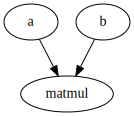

In [6]:
tf_to_dot(graph, display_all_nodes=True)

### Constants, variables and graph collections


- **Constants**: Creating a `tf.constant` creates a `tf.Operation` and adds it to the default graph and returns a `tf.Tensor` that represents the value.

- [**Variables**](https://www.tensorflow.org/programmers_guide/variables): Creating a [`tf.Variable`](https://www.tensorflow.org/api_docs/python/tf/Variable) adds to the graph a `tf.Operation` that will store a writeable tensor value that persists between `tf.Session.run` calls. 

By default every `tf.Variable` gets placed in the following two collections: 
* `tf.GraphKeys.GLOBAL_VARIABLES` --- variables that can be shared across multiple devices, 
* `tf.GraphKeys.TRAINABLE_VARIABLES` --- variables for which TensorFlow will calculate gradients.


In [7]:
tf.reset_default_graph()
c = tf.constant(1.2345, name='1.2345_constant')
v = tf.Variable(initial_value=0.0, dtype=tf.float32, name="Trainable_variable")
v2 = tf.Variable(initial_value=0.0, trainable=False, dtype=tf.float32, name="Non-trainable_variable")

In [8]:
graph = tf.get_default_graph()
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation '1.2345_constant' type=Const>
<tf.Operation 'Trainable_variable/initial_value' type=Const>
<tf.Operation 'Trainable_variable' type=VariableV2>
<tf.Operation 'Trainable_variable/Assign' type=Assign>
<tf.Operation 'Trainable_variable/read' type=Identity>
<tf.Operation 'Non-trainable_variable/initial_value' type=Const>
<tf.Operation 'Non-trainable_variable' type=VariableV2>
<tf.Operation 'Non-trainable_variable/Assign' type=Assign>
<tf.Operation 'Non-trainable_variable/read' type=Identity>

 - Tensors (edges): 

Tensor("Trainable_variable/read:0", shape=(), dtype=float32)
Tensor("Trainable_variable/Assign:0", shape=(), dtype=float32_ref)
Tensor("Non-trainable_variable/Assign:0", shape=(), dtype=float32_ref)
Tensor("Non-trainable_variable/read:0", shape=(), dtype=float32)
Tensor("1.2345_constant:0", shape=(), dtype=float32)
Tensor("Trainable_variable/initial_value:0", shape=(), dtype=float32)
Tensor("Non-trainable_variable/ini

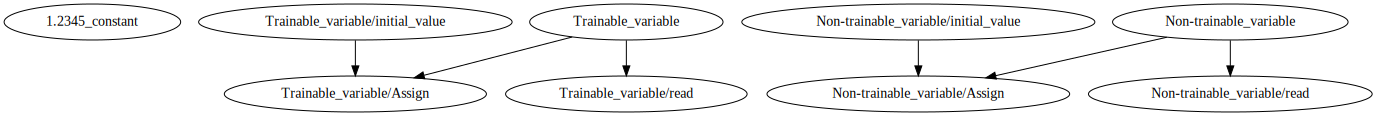

In [9]:
tf_to_dot(graph, display_all_nodes=True)

### Session run  and `control_dependencies`

Once graph is built we can execute its computation within a session.

Let's consider two examples that compute a normalized value from an input value:
```
y = (x - mean) / (variance + eps)
```
in the first version mean and variance are constant and in the second they are computed with exponential moving decay.

#### Constant mean/variance

In [10]:
tf.reset_default_graph()
graph = tf.get_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(1, ), name='X')
mean = tf.Variable(initial_value=0.0, trainable=False, name='X_mean')
variance = tf.Variable(initial_value=1.0, trainable=False, name='X_variance')
eps = tf.constant(1e-10, dtype=tf.float32, name='Epsilon')
y = tf.identity((x - mean) / (variance + eps), name='Y')

In [11]:
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation 'X' type=Placeholder>
<tf.Operation 'X_mean/initial_value' type=Const>
<tf.Operation 'X_mean' type=VariableV2>
<tf.Operation 'X_mean/Assign' type=Assign>
<tf.Operation 'X_mean/read' type=Identity>
<tf.Operation 'X_variance/initial_value' type=Const>
<tf.Operation 'X_variance' type=VariableV2>
<tf.Operation 'X_variance/Assign' type=Assign>
<tf.Operation 'X_variance/read' type=Identity>
<tf.Operation 'Epsilon' type=Const>
<tf.Operation 'sub' type=Sub>
<tf.Operation 'add' type=Add>
<tf.Operation 'truediv' type=RealDiv>
<tf.Operation 'Y' type=Identity>

 - Tensors (edges): 

Tensor("X_variance/read:0", shape=(), dtype=float32)
Tensor("X_variance/initial_value:0", shape=(), dtype=float32)
Tensor("Epsilon:0", shape=(), dtype=float32)
Tensor("sub:0", shape=(1,), dtype=float32)
Tensor("X_mean/initial_value:0", shape=(), dtype=float32)
Tensor("X_variance:0", shape=(), dtype=float32_ref)
Tensor("X_variance/Assign:0", shape=(), dtype

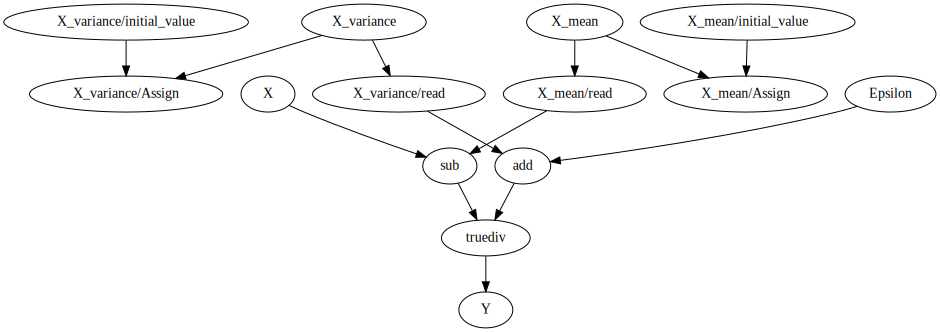

In [12]:
tf_to_dot(graph, display_all_nodes=True)

In [13]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [16]:
n = 100
res = np.zeros((n, 2))
with tf.Session() as sess, graph.as_default():
    for i in range(n):
        feed_dict = {
            x: np.sin(2.0 / 12.0 *np.pi* i ) + np.random.randn(1),
            mean: 5.0,
            variance: 2.0
        }
        res[i, 0] = sess.run(x, feed_dict=feed_dict)
        res[i, 1] = sess.run(y, feed_dict=feed_dict)        

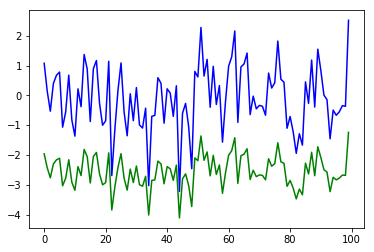

In [17]:
plt.plot(res[:, 0], 'b')
plt.plot(res[:, 1], 'g')

#### Variable mean/variance

In [46]:
tf.reset_default_graph()
graph = tf.get_default_graph()

decay = 0.85

x = tf.placeholder(dtype=tf.float32, shape=[1], name='X')

# Create an ExponentialMovingAverage object
ema = tf.train.ExponentialMovingAverage(decay=decay)

_x_mean = tf.Variable(tf.constant(0.0, shape=[1]), name='X_mean_variable')               
assign_x_mean = tf.identity(_x_mean.assign(x), name='assign_X_mean')
maintain_x_mean_op = ema.apply([assign_x_mean])
with tf.control_dependencies([maintain_x_mean_op]):
    x_mean = tf.identity(ema.average(assign_x_mean), name='X_mean')

_x_variance = tf.Variable(tf.constant(1.0, shape=[1]), name='X_variance_variable')
assign_x_variance = tf.identity(_x_variance.assign(tf.pow(x-x_mean, 2.0)), name='assign_X_variance')
maintain_x_variance_op = ema.apply([assign_x_variance])
with tf.control_dependencies([maintain_x_variance_op]):
    x_variance = tf.identity(ema.average(assign_x_variance), name='X_variance')
        
eps = tf.constant(1e-10, dtype=tf.float32, name='Epsilon')

# The following updates mean/variance before computing y
y = tf.identity((x - x_mean) / (x_variance + eps), name='Y')

In [47]:
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation 'X' type=Placeholder>
<tf.Operation 'Const' type=Const>
<tf.Operation 'X_mean_variable' type=VariableV2>
<tf.Operation 'X_mean_variable/Assign' type=Assign>
<tf.Operation 'X_mean_variable/read' type=Identity>
<tf.Operation 'Assign' type=Assign>
<tf.Operation 'assign_X_mean' type=Identity>
<tf.Operation 'assign_X_mean/ExponentialMovingAverage/Initializer/zeros' type=Const>
<tf.Operation 'assign_X_mean/ExponentialMovingAverage' type=VariableV2>
<tf.Operation 'assign_X_mean/ExponentialMovingAverage/Assign' type=Assign>
<tf.Operation 'assign_X_mean/ExponentialMovingAverage/read' type=Identity>
<tf.Operation 'ExponentialMovingAverage/decay' type=Const>
<tf.Operation 'ExponentialMovingAverage/AssignMovingAvg/sub/x' type=Const>
<tf.Operation 'ExponentialMovingAverage/AssignMovingAvg/sub' type=Sub>
<tf.Operation 'ExponentialMovingAverage/AssignMovingAvg/sub_1' type=Sub>
<tf.Operation 'ExponentialMovingAverage/AssignMovingAvg/mul' 

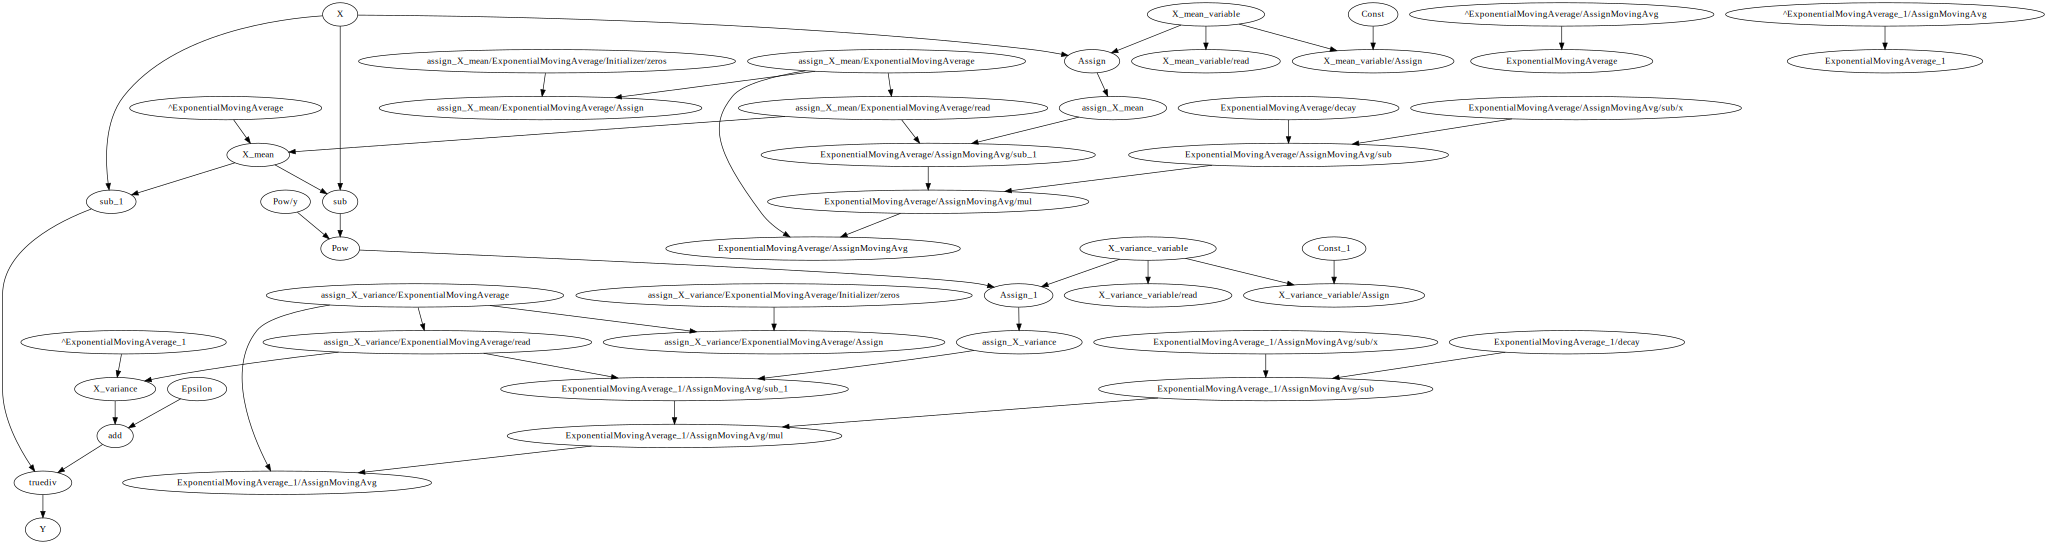

In [48]:
tf_to_dot(graph, display_all_nodes=True)

In [50]:
n = 100
res = np.zeros((n, 4))
np_res = np.zeros((n, 2))
np_x_mean = 0.0
np_x_var = 1.0
with tf.Session() as sess, graph.as_default():
    sess.run(tf.global_variables_initializer())
    for i in range(n):
        np_res[i, 0] = 2.0 *np.sin(2.0 / 12.0 *np.pi* i ) + np.random.randn(1)
        if i == 0:
            np_x_mean = np_res[0, 0]
            np_x_var = np.power(np_res[0, 0] - np_x_mean, 2.0)            
        np_x_mean -= (1-decay) * (np_x_mean - np_res[i, 0])
        np_x_var -= (1-decay) * (np_x_var - np.power(np_res[i, 0] - np_x_mean, 2.0))
        
        feed_dict = {
            x: [np_res[i, 0]],
        }
        res[i, :] = sess.run([x, x_mean, x_variance, y], feed_dict=feed_dict)
        np_res[i, 1] = (np_res[i, 0] - np_x_mean) / (np_x_var + 1e-5)

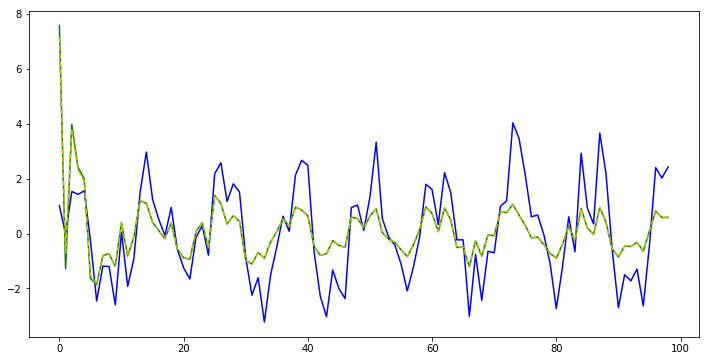

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(res[1:, 0], 'b')
plt.plot(res[1:, 3], 'g')
plt.plot(np_res[1:, 1], 'y--')